# UiBench benchmark on Android

This benchmark is used to evaluate the responsiveness of an Android system to user interaction. Also **systraces** are captured during the benchmark run and represented at the end of the notebook.

In [1]:
import logging

from conf import LisaLogging
LisaLogging.setup()

2016-12-09 13:51:08,534 INFO    : root         : Using LISA logging configuration:
2016-12-09 13:51:08,534 INFO    : root         :   /home/vagrant/lisa/logging.conf


In [2]:
%pylab inline

import json
import os

# Support to access the remote target
import devlib
from env import TestEnv

# Import support for Android devices
from android import Screen, Workload, System

# Support for trace events analysis
from trace import Trace
#from trace_analysis import TraceAnalysis

# Suport for FTrace events parsing and visualization
import trappy

import pandas as pd
import sqlite3

Populating the interactive namespace from numpy and matplotlib


## Support Functions

This function helps us run our experiments:

In [3]:
def experiment():
    # Unlock device screen (assume no password required)
    target.execute('input keyevent 82')
    
    # Configure governor
    target.cpufreq.set_all_governors('sched')
    
    # Configure screen to max brightness and no dimming
    Screen.set_brightness(target, percent=100)
    Screen.set_dim(target, auto=False)
    Screen.set_timeout(target, 60*60*10) # 10 hours should be enought for an experiment
    
    wload = Workload(te).get(te, 'UiBench')
    
    # Start systrace
    trace_file = os.path.join(te.res_dir, 'trace.html')
    systrace_output = System.systrace_start(te, trace_file, 15)
    
    # UiBench
    db_file, nrg_report = wload.run(te.res_dir, 'TrivialAnimation', duration_s=10, collect='systrace')

    if systrace_output:
        logging.info('Waiting systrace report [%s]...', trace_file)
        systrace_output.wait()
    else:
        logging.warning('Systrace is not running!')

    # Reset screen brightness and auto dimming
    Screen.set_defaults(target)
        
    # Dump platform descriptor
    te.platform_dump(te.res_dir)

    # return all the experiment data
    return {
       'dir'             : te.res_dir,
       'db_file'         : db_file,
       'nrg_report'      : nrg_report,
       'trace_file'      : trace_file,
    }

## Test environment setup
For more details on this please check out **examples/utils/testenv_example.ipynb**.

**devlib** requires the ANDROID_HOME environment variable configured to point to your local installation of the Android SDK. If you have not this variable configured in the shell used to start the notebook server, you need to run a cell to define where your Android SDK is installed or specify the ANDROID_HOME in your target configuration.

In case more than one Android device are conencted to the host, you must specify the ID of the device you want to target in **my_target_conf**. Run **adb devices** on your host to get the ID.

In [4]:
# Setup target configuration
my_conf = {

    # Target platform and board
    "platform"     : 'android',
    "board"        : 'pixel',
    
    # Device
    "device"       : "HT6670300102",
    
    # Android home
    "ANDROID_HOME" : "/home/vagrant/lisa/tools/android-sdk-linux",

    # Folder where all the results will be collected
    "results_dir" : "UiBench_example",

    # Define devlib modules to load
    "modules"     : [
        'cpufreq'       # enable CPUFreq support
    ],

    # FTrace events to collect for all the tests configuration which have
    # the "ftrace" flag enabled
    "ftrace"  : {
         "events" : [
            "sched_switch",
            "sched_wakeup",
            "sched_wakeup_new",
            "sched_overutilized",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
            "cpu_capacity",
            "cpu_frequency",
         ],
         "buffsize" : 100 * 1024,
    },

    # Tools required by the experiments
    "tools"   : [ 'trace-cmd', 'taskset'],
}

In [5]:
# Initialize a test environment using:
te = TestEnv(my_conf, wipe=False)
target = te.target

2016-12-09 13:51:26,134 INFO    : TestEnv      : Using base path: /home/vagrant/lisa
2016-12-09 13:51:26,134 INFO    : TestEnv      : Loading custom (inline) target configuration
2016-12-09 13:51:26,135 INFO    : TestEnv      : External tools using:
2016-12-09 13:51:26,135 INFO    : TestEnv      :    ANDROID_HOME: /home/vagrant/lisa/tools/android-sdk-linux
2016-12-09 13:51:26,136 INFO    : TestEnv      :    CATAPULT_HOME: /home/vagrant/lisa/tools/catapult
2016-12-09 13:51:26,136 INFO    : TestEnv      : Loading board:
2016-12-09 13:51:26,137 INFO    : TestEnv      :    /home/vagrant/lisa/libs/utils/platforms/pixel.json
2016-12-09 13:51:26,138 INFO    : TestEnv      : Devlib modules to load: [u'bl', u'cpufreq']
2016-12-09 13:51:26,138 INFO    : TestEnv      : Connecting Android target [HT6670300102]
2016-12-09 13:51:26,138 INFO    : TestEnv      : Connection settings:
2016-12-09 13:51:26,139 INFO    : TestEnv      :    {'device': 'HT6670300102'}
2016-12-09 13:51:26,305 INFO    : android

## Workloads execution

This is done using the **experiment** helper function defined above which is configured to run a **UiBench - TrivialAnimation** experiment.

In [6]:
# Intialize Workloads for this test environment
results = experiment()

2016-12-09 13:52:24,254 INFO    : Screen       : Set brightness: 100%
2016-12-09 13:52:24,721 INFO    : Screen       : Dim screen mode: OFF
2016-12-09 13:52:25,261 INFO    : Screen       : Screen timeout: 36000 [s]
2016-12-09 13:52:26,884 INFO    : Workload     : Workloads available on target:
2016-12-09 13:52:26,887 INFO    : Workload     :   ['YouTube', 'Jankbench', 'UiBench']
2016-12-09 13:52:26,888 INFO    : Workload     : Workloads available on target:
2016-12-09 13:52:26,890 INFO    : Workload     :   ['YouTube', 'Jankbench', 'UiBench']
2016-12-09 13:52:26,891 INFO    : System       : SysTrace: /home/vagrant/lisa/tools/catapult/systrace/systrace/run_systrace.py -e HT6670300102 -o /home/vagrant/lisa/results/UiBench_example/trace.html gfx view sched freq idle -t 15
2016-12-09 13:52:30,694 INFO    : Screen       : Force manual orientation
2016-12-09 13:52:30,697 INFO    : Screen       : Set orientation: PORTRAIT
2016-12-09 13:52:33,085 INFO    : UiBench      : adb -s HT6670300102 lo

## Benchmarks results

In [7]:
# Benchmark statistics
!sed '/Stats since/,/99th/!d;/99th/q' {results['db_file']}

# For all results:
# !cat {results['db_file']}

Stats since: 94537383291004ns
Total frames rendered: 625
Janky frames: 26 (4.16%)
50th percentile: 8ms
90th percentile: 13ms
95th percentile: 15ms
99th percentile: 26ms


## Traces visualisation

For more information on this please check **examples/trace_analysis/TraceAnalysis_TasksLatencies.ipynb**.

In [8]:
# Parse all traces
platform_file = os.path.join(te.res_dir, 'platform.json')
with open(platform_file, 'r') as fh:
    platform = json.load(fh)
trace_file = os.path.join(te.res_dir, 'trace.html')
trace = Trace(platform, trace_file, events=my_conf['ftrace']['events'])

trappy.plotter.plot_trace(trace.ftrace)

2016-12-09 13:53:30,879 INFO    : Trace        : Parsing SysTrace format...
2016-12-09 13:53:35,029 INFO    : Trace        : Platform clusters verified to be Frequency coherent
2016-12-09 13:53:36,579 INFO    : Trace        : Collected events spans a 12.543 [s] time interval
2016-12-09 13:53:36,579 INFO    : Trace        : Set plots time range to (0.000000, 12.543107)[s]
2016-12-09 13:53:36,580 INFO    : Analysis     : Registering trace analysis modules:
2016-12-09 13:53:36,581 INFO    : Analysis     :    tasks
2016-12-09 13:53:36,582 INFO    : Analysis     :    status
2016-12-09 13:53:36,583 INFO    : Analysis     :    frequency
2016-12-09 13:53:36,583 INFO    : Analysis     :    cpus
2016-12-09 13:53:36,584 INFO    : Analysis     :    latency
2016-12-09 13:53:36,585 INFO    : Analysis     :    idle
2016-12-09 13:53:36,586 INFO    : Analysis     :    functions
2016-12-09 13:53:36,586 INFO    : Analysis     :    eas


2016-12-09 13:53:47,779 WARNING : Analysis     : Event [sched_overutilized] not found, plot DISABLED!
2016-12-09 13:53:47,801 WARNING : Analysis     : Event [sched_overutilized] not found, plot DISABLED!
2016-12-09 13:53:48,053 INFO    : Analysis     : LITTLE cluster average frequency: 0.672 GHz
2016-12-09 13:53:48,054 INFO    : Analysis     : big    cluster average frequency: 0.892 GHz
2016-12-09 13:53:48,054 INFO    : root         : Plotting cluster frequencies for [sched]...


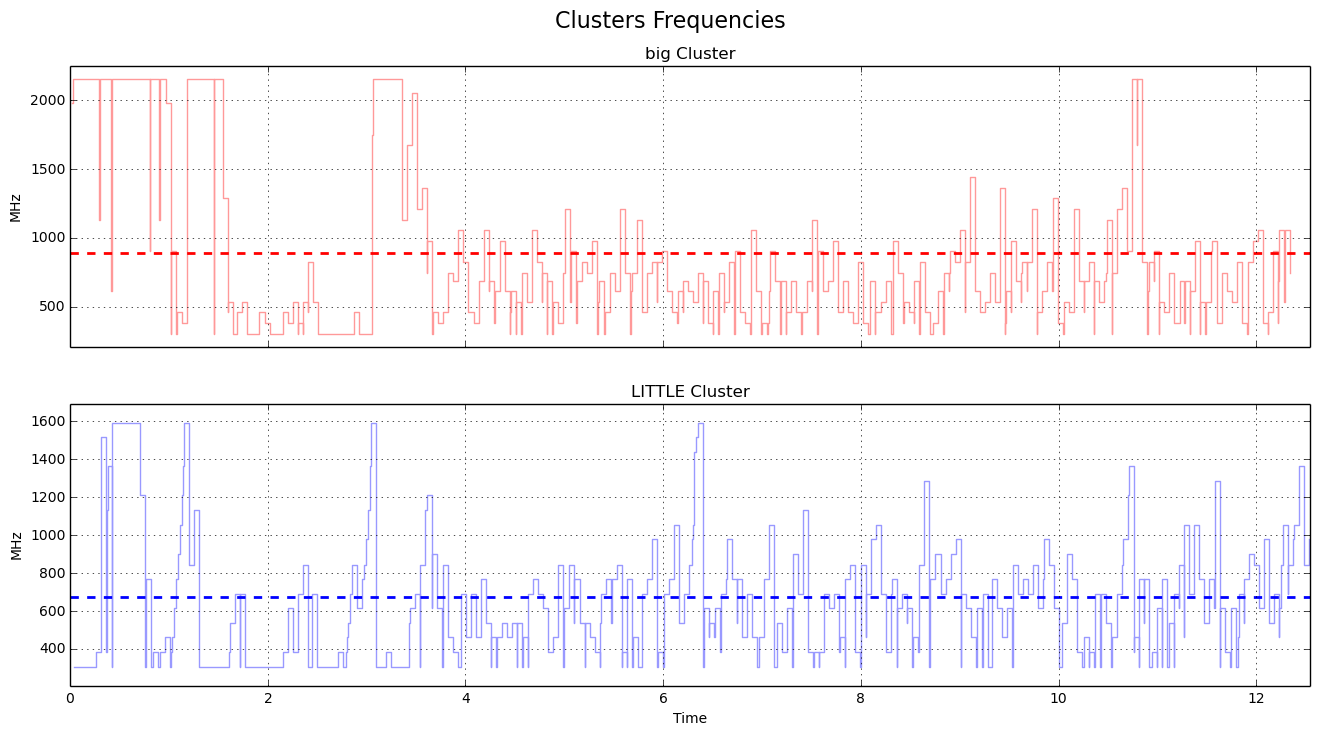

In [9]:
try:
    trace.analysis.frequency.plotClusterFrequencies();
    logging.info('Plotting cluster frequencies for [sched]...')
except: pass